In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import metpy
import requests
import matplotlib.pyplot as pl
import matplotlib.patheffects as pe
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from metpy.plots import ctables
from osgeo import osr
from wradlib.io.xarray import CfRadial, OdimH5

import urllib
import io
import glob

try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

from html.parser import HTMLParser

class DWDHTMLParser(HTMLParser):
    def handle_starttag(self, tag, attrs):
        if tag != 'a':
            return
        self.links.append(attrs[0][1])

parser = DWDHTMLParser()

radar = 'NHB'
DBZH = 'sweep_pcp_z'
VRADH = 'sweep_vol_v'

opendata_url1 = (f"https://opendata.dwd.de/weather/radar/sites/{DBZH}/{radar.lower()}/hdf5/filter_polarimetric/")
with urllib.request.urlopen(opendata_url1) as url_request:
    response = url_request.read().decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]
filelist1.sort(key=lambda x: x.split('-')[2])
filelist1.reverse()

for f in filelist1[:1]:
    urllib.request.urlretrieve(os.path.join(opendata_url1, f), f)

flist = glob.glob('ras07-*')
vol = wrl.io.OdimH5(flist, standard='cf', georef=True)

list(vol)
time = vol.root.time_coverage_end

print(time.item())

time = time.item()

import dateutil.parser
time = dateutil.parser.parse(time)
time2 = time.strftime("%Y%m%d%H%M")
print(time2)

flist = glob.glob('ras07*')
for f in flist:
    os.remove(f)
    
vol.root

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_boundary_lines_land',
                                           scale='10m',
                                           facecolor='none')
    ax.add_feature(borders, edgecolor='black', lw=4, zorder=4)

map_trans = ccrs.AzimuthalEquidistant(central_latitude=vol['sweep_1'].latitude.values,
                                      central_longitude=vol['sweep_1'].longitude.values)

def plot_borders2(ax):
    filename = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_0.shp')
    filename3 = wrl.util.get_wradlib_data_file('geo/gadm36_BEL_0.shp')
    filename4 = wrl.util.get_wradlib_data_file('geo/gadm36_FRA_0.shp')
    filename5 = wrl.util.get_wradlib_data_file('geo/gadm36_DEU_0.shp')
    dataset, inLayer = wrl.io.open_vector(filename)
    dataset3, inLayer3 = wrl.io.open_vector(filename3)
    dataset4, inLayer4 = wrl.io.open_vector(filename4)
    dataset5, inLayer5 = wrl.io.open_vector(filename5)
    borders, keys = wrl.georef.get_vector_coordinates(inLayer)
    borders3, keys3 = wrl.georef.get_vector_coordinates(inLayer3)
    borders4, keys4 = wrl.georef.get_vector_coordinates(inLayer4)
    borders5, keys5 = wrl.georef.get_vector_coordinates(inLayer5)
    wrl.vis.add_lines(ax, borders, color='black', lw=2, zorder=4,transform=ccrs.PlateCarree())
    wrl.vis.add_lines(ax, borders3, color='black', lw=2, zorder=4,transform=ccrs.PlateCarree())
    wrl.vis.add_lines(ax, borders4, color='black', lw=2, zorder=4,transform=ccrs.PlateCarree())
    wrl.vis.add_lines(ax, borders5, color='black', lw=2, zorder=4,transform=ccrs.PlateCarree())
    
def plot_cant(ax):
    filename6 = wrl.util.get_wradlib_data_file('geo/gadm36_LUX_2.shp')
    dataset6, inLayer6 = wrl.io.open_vector(filename6)
    borders6, keys6 = wrl.georef.get_vector_coordinates(inLayer6)
    wrl.vis.add_lines(ax, borders6, color='grey', lw=0.75, zorder=4,transform=ccrs.PlateCarree())

#def plot_cities(ax):
#    lats = [49.75,49.627,49.5,49.66,49.97,49.545,49.556,49.83]
#    lons = [6.1,6.21,5.99,5.92,5.93,6.367,5.875,5.85]
#    cities = ['Mersch','Findel','Esch/Alzette','Steinfort','Wiltz','Remich','Pétange','Rambrouch']
#    for lon, lat, city in zip(lons, lats, cities):
#        ax.plot(lon, lat, 'k+', zorder=5, transform=ccrs.PlateCarree())
#        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
#                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
#                transform=ccrs.PlateCarree())
        
def plot_cities(ax):
    lats = [49.85,49.627,49.5,49.97]
    lons = [6.1,6.21,5.99,5.93]
    cities = ['Ettelbruck','Findel','Esch/Alzette','Wiltz']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'k+', zorder=5, transform=ccrs.PlateCarree())
        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
        
def plot_radloc(ax):
    lats = [50.1097]
    lons = [6.5483]
    cities = ['']
    for lon, lat, city in zip(lons, lats, cities):
        ax.plot(lon, lat, 'ro', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
        ax.text(lon + 0.01, lat + 0.01, city, fontsize='14', color='white', 
                path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())

2021-07-03T12:45:33Z
202107031245


In [3]:
opendata_url1 = (f"https://opendata.dwd.de/weather/radar/mesocyclones/")
with urllib.request.urlopen(opendata_url1) as url_request:
    response = url_request.read().decode("utf-8")

parser.links = []
parser.feed(response)
filelist1 = parser.links[1:]

filelist1.sort(key=lambda x: x.split('_')[0])
filelist1.reverse()

for f in filelist1[:1]:
    urllib.request.urlretrieve(os.path.join(opendata_url1, f), f)

flist = glob.glob('meso_2*')

print(f)

import xml.etree.ElementTree as ET
#root = ET.parse('/home/lmathias/Documents/severeweather/TORNADO20190809/MCD/meso_20190809_1540.xml').getroot()
#root = ET.parse('/home/lmathias/Documents/severeweather/TSTORM20200612/meso/meso_20200612_1700.xml').getroot()
root = ET.parse('/home/lmathias/Documents/wradlib/nhb/mcd/meso_latest.xml').getroot()

for type_tag in root.findall('event'):
    event = type_tag.get('ID')
    print(event)
    
for type_tag in root.findall('event/time'):
    time3 = type_tag.text
#print(time3)
    
latitude = []
for type_tag in root.findall('event/location/area/ellipse/moving-point/latitude'):
    lat = type_tag.text
    latitude.append(float(lat))
print(latitude)

longitude = []
for type_tag in root.findall('event/location/area/ellipse/moving-point/longitude'):
    lon = type_tag.text
    longitude.append(float(lon))
print(longitude)
    
sev = []
for type_tag in root.findall('event/nowcast-parameters/meso_intensity'):
    i = type_tag.text
    sev.append(float(i))
print(sev)

base= []
for type_tag in root.findall('event/nowcast-parameters/mesocyclone_base'):
    b = type_tag.text
    base.append(float(b))
print(base)

top= []
for type_tag in root.findall('event/nowcast-parameters/mesocyclone_top'):
    t = type_tag.text
    top.append(float(t))
print(top)

vmaxrot= []
for type_tag in root.findall('event/nowcast-parameters/mesocyclone_velocity_rotational_max'):
    v = type_tag.text
    vmaxrot.append(float(v))
print(vmaxrot)

diam= []
for type_tag in root.findall('event/nowcast-parameters/mesocyclone_diameter_equivalent'):
    d = type_tag.text
    diam.append(float(d))
print(diam)

size = len(latitude)
print(size)

lats=[]
lons=[]
severity=[]
mbase=[]
mtop=[]
vmrot=[]
dmeq=[]

def plot_meso(ax):
    for i in range(size):
        lats.append(latitude[i])
        lons.append(longitude[i])
        severity.append(sev[i])
        mbase.append(base[i])
        mtop.append(top[i])
        vmrot.append(vmaxrot[i])
        dmeq.append(diam[i])
    for lon, lat, s, b, t, vmr, d in zip(lons, lats, severity, mbase, mtop, vmrot, dmeq):
        if lat>49.3 and lat<50.3 and lon<6.8 and lon>5.4:
            if s==1:
                ax.plot(lon, lat, marker=(3, 0, 180), markersize=25, markeredgewidth=1.5, color='lime', markeredgecolor='black', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat+0.025, round(t,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat-0.065, round(b,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon+0.1, lat-0.02, round(vmr,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon-0.1, lat-0.02, round(d,1), fontsize='14', color='white', ha='center', zorder=5, 
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
            if s==2:
                ax.plot(lon, lat, marker=(3, 0, 180), markersize=25, markeredgewidth=1.5, color='yellow', markeredgecolor='black', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat+0.025, round(t,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat-0.065, round(b,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon+0.1, lat-0.02, round(vmr,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon-0.1, lat-0.02, round(d,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
            if s==3:
                ax.plot(lon, lat, marker=(3, 0, 180), markersize=25, markeredgewidth=1.5, color='orange', markeredgecolor='black', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat+0.025, round(t,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat-0.065, round(b,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon+0.1, lat-0.02, round(vmr,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon-0.1, lat-0.02, round(d,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
            if s==4:
                ax.plot(lon, lat, marker=(3, 0, 180), markersize=25, markeredgewidth=1.5, color='red', markeredgecolor='black', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat+0.025, round(t,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat-0.065, round(b,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon+0.1, lat-0.02, round(vmr,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon-0.1, lat-0.02, round(d,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
            if s==5:
                ax.plot(lon, lat, marker=(3, 0, 180), markersize=25, markeredgewidth=1.5, color='magenta', markeredgecolor='black', zorder=5, path_effects=[pe.withStroke(linewidth=2.5, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat+0.025, round(t,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon, lat-0.065, round(b,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon+0.1, lat-0.02, round(vmr,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())
                ax.text(lon-0.1, lat-0.02, round(d,1), fontsize='14', color='white', ha='center', zorder=5,
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
                transform=ccrs.PlateCarree())

meso_latest.xml
[]
[]
[]
[]
[]
[]
[]
0


dwd_meso_202107031245.jpeg


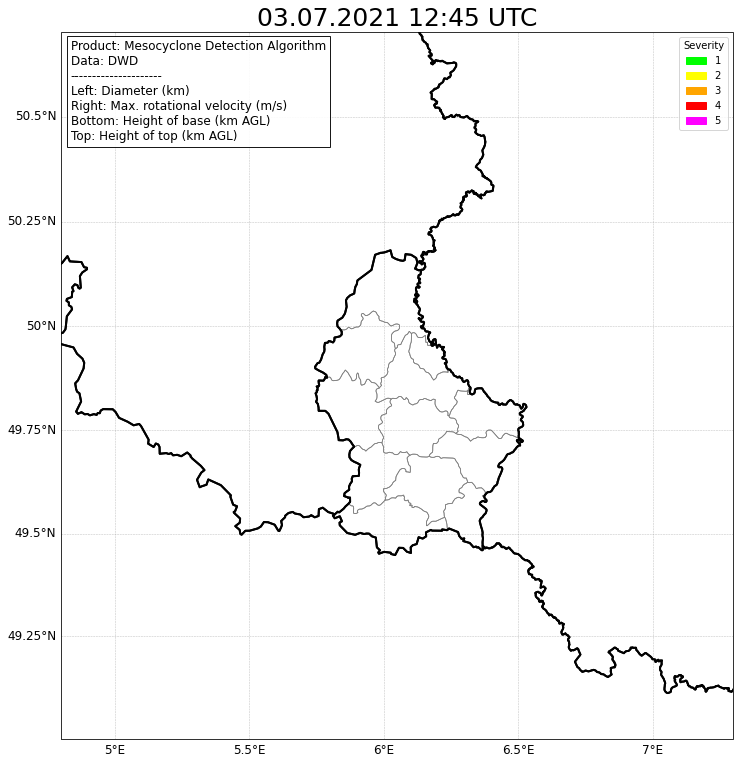

In [4]:
map_proj = ccrs.Mercator(central_longitude=vol['sweep_1'].longitude.values)
fig = pl.figure(figsize=(15,13))
ax = fig.add_subplot(111, projection=map_proj)


colors=[(0.0, 0.9254901960784314, 0.9254901960784314), 
                    (0.00392156862745098, 0.6274509803921569, 0.9647058823529412), 
                    (0.0, 0.0, 0.9647058823529412), 
                    (0.0, 1.0, 0.0), 
                    (0.0, 0.7843137254901961, 0.0), 
                    (0.0, 0.5647058823529412, 0.0), 
                    (1.0, 1.0, 0.0), 
                    (0.9058823529411765, 0.7529411764705882, 0.0), 
                    (1.0, 0.5647058823529412, 0.0), 
                    (1.0, 0.16078431372, 0.16078431372), 
                    (0.7529411764705882, 0.0, 0.0),
                    (0.59765625, 0.0, 0.0), 
                    (1.0, 0.0, 1.0), 
                    (0.6, 0.3333333333333333, 0.788235294117647), 
                    (0.8984375, 0.8984375, 0.8984375)]
cmap1 = ListedColormap(colors)
cmap = ctables.colortables.get_colortable('NWSStormClearReflectivity')

newcmap = ListedColormap(cmap(np.linspace(0.25, 0.92, 28)))

DBZH = vol['sweep_1'].DBZH
#pm = DBZH.where(DBZH>-1).wradlib.plot_ppi(ax=ax, cmap=newcmap, fig=fig, vmin=0,vmax=70)
gl = ax.gridlines(draw_labels=True,linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12, 'color': 'black'}
gl.ylabel_style = {'size': 12, 'color': 'black'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.set_extent([4.8, 7.3, 49, 50.7])
txt = pl.title(time.strftime("%d.%m.%Y %H:%M UTC"),fontsize=25)
#cb = pl.colorbar(pm, ax=ax, shrink=0.9, ticks=[-20,-10,0,10,20,30,40,50,60,70],orientation='vertical')
#cb.set_label("dBZ",fontsize=20)
#cb.ax.tick_params(labelsize=20)

import matplotlib.patches as mpatches
patch1 = mpatches.Patch(color='lime', label='1')
patch2 = mpatches.Patch(color='yellow', label='2')
patch3 = mpatches.Patch(color='orange', label='3')
patch4 = mpatches.Patch(color='red', label='4')
patch5 = mpatches.Patch(color='magenta', label='5')
pl.legend(handles=[patch1, patch2, patch3, patch4, patch5], title="Severity", fancybox = True)

plot_cant(ax)
plot_borders2(ax)
plot_meso(ax)
#plot_cities(ax)
#plot_radloc(ax)
pl.gca().set_aspect('equal')
t=pl.gcf().text(0.21, 0.765, 'Product: Mesocyclone Detection Algorithm\nData: DWD\n---------------------\nLeft: Diameter (km)\nRight: Max. rotational velocity (m/s)\nBottom: Height of base (km AGL)\nTop: Height of top (km AGL)', fontsize=12)
t.set_bbox(dict(facecolor='white', alpha=0.9, edgecolor='black'))

base_filename='dwd_meso_'
suffix='.jpeg'
latest='latest'
#endfile=os.path.join(dir_name,base_filename+rwattrs['datetime'].strftime("%Y%m%d%H%M")+suffix)
#print(endfile)
#fig.savefig('endfile')
my_file = base_filename+time2+suffix
#my_file2 = base_filename+latest+suffix
print(my_file)
#print(my_file2)
if os.path.isfile(my_file):
   os.remove(my_file)   # Opt.: os.system("rm "+strFile)
pl.savefig(my_file, bbox_inches='tight')